# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [21]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

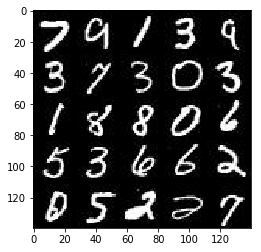

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

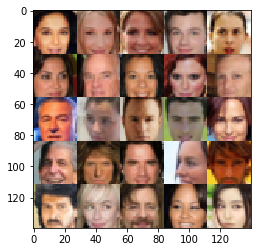

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [25]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.0384... Generator Loss: 3.5225
Epoch 1/2... Batch 20... Discriminator Loss: 0.1166... Generator Loss: 22.9160
Epoch 1/2... Batch 30... Discriminator Loss: 0.6977... Generator Loss: 1.6800
Epoch 1/2... Batch 40... Discriminator Loss: 0.1508... Generator Loss: 12.6954
Epoch 1/2... Batch 50... Discriminator Loss: 0.1316... Generator Loss: 3.7808
Epoch 1/2... Batch 60... Discriminator Loss: 0.0168... Generator Loss: 13.7446
Epoch 1/2... Batch 70... Discriminator Loss: 0.9258... Generator Loss: 2.6936
Epoch 1/2... Batch 80... Discriminator Loss: 0.2690... Generator Loss: 2.8882
Epoch 1/2... Batch 90... Discriminator Loss: 0.2698... Generator Loss: 2.0757
Epoch 1/2... Batch 100... Discriminator Loss: 0.1982... Generator Loss: 2.4517


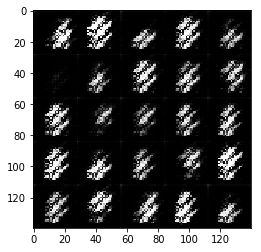

Epoch 1/2... Batch 110... Discriminator Loss: 0.5614... Generator Loss: 1.2470
Epoch 1/2... Batch 120... Discriminator Loss: 0.2020... Generator Loss: 2.1582
Epoch 1/2... Batch 130... Discriminator Loss: 0.8888... Generator Loss: 7.4021
Epoch 1/2... Batch 140... Discriminator Loss: 0.1618... Generator Loss: 5.0145
Epoch 1/2... Batch 150... Discriminator Loss: 0.4723... Generator Loss: 2.0963
Epoch 1/2... Batch 160... Discriminator Loss: 0.3018... Generator Loss: 3.7933
Epoch 1/2... Batch 170... Discriminator Loss: 0.5023... Generator Loss: 6.3012
Epoch 1/2... Batch 180... Discriminator Loss: 0.3502... Generator Loss: 4.4475
Epoch 1/2... Batch 190... Discriminator Loss: 0.2106... Generator Loss: 4.5171
Epoch 1/2... Batch 200... Discriminator Loss: 1.0428... Generator Loss: 0.7192


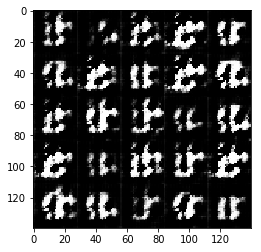

Epoch 1/2... Batch 210... Discriminator Loss: 0.3093... Generator Loss: 2.9871
Epoch 1/2... Batch 220... Discriminator Loss: 0.3472... Generator Loss: 6.6171
Epoch 1/2... Batch 230... Discriminator Loss: 0.1391... Generator Loss: 4.9357
Epoch 1/2... Batch 240... Discriminator Loss: 0.6568... Generator Loss: 1.6697
Epoch 1/2... Batch 250... Discriminator Loss: 0.4252... Generator Loss: 4.6817
Epoch 1/2... Batch 260... Discriminator Loss: 0.4291... Generator Loss: 4.5136
Epoch 1/2... Batch 270... Discriminator Loss: 0.2681... Generator Loss: 2.8072
Epoch 1/2... Batch 280... Discriminator Loss: 1.0535... Generator Loss: 7.0737
Epoch 1/2... Batch 290... Discriminator Loss: 0.2586... Generator Loss: 3.4674
Epoch 1/2... Batch 300... Discriminator Loss: 0.4759... Generator Loss: 5.2915


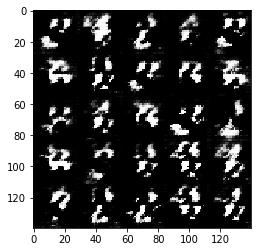

Epoch 1/2... Batch 310... Discriminator Loss: 0.0857... Generator Loss: 6.1144
Epoch 1/2... Batch 320... Discriminator Loss: 0.5291... Generator Loss: 1.6797
Epoch 1/2... Batch 330... Discriminator Loss: 1.0219... Generator Loss: 6.2446
Epoch 1/2... Batch 340... Discriminator Loss: 1.1611... Generator Loss: 4.0550
Epoch 1/2... Batch 350... Discriminator Loss: 0.6051... Generator Loss: 1.4807
Epoch 1/2... Batch 360... Discriminator Loss: 0.3372... Generator Loss: 2.2781
Epoch 1/2... Batch 370... Discriminator Loss: 0.3857... Generator Loss: 1.6734
Epoch 1/2... Batch 380... Discriminator Loss: 0.3858... Generator Loss: 3.1837
Epoch 1/2... Batch 390... Discriminator Loss: 0.5826... Generator Loss: 1.3573
Epoch 1/2... Batch 400... Discriminator Loss: 0.4099... Generator Loss: 1.6488


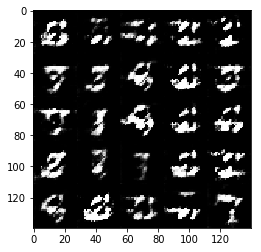

Epoch 1/2... Batch 410... Discriminator Loss: 0.7038... Generator Loss: 1.1713
Epoch 1/2... Batch 420... Discriminator Loss: 1.4787... Generator Loss: 0.5288
Epoch 1/2... Batch 430... Discriminator Loss: 0.3841... Generator Loss: 2.3406
Epoch 1/2... Batch 440... Discriminator Loss: 0.3455... Generator Loss: 2.6684
Epoch 1/2... Batch 450... Discriminator Loss: 0.5840... Generator Loss: 3.2168
Epoch 1/2... Batch 460... Discriminator Loss: 1.5730... Generator Loss: 0.3867
Epoch 2/2... Batch 10... Discriminator Loss: 0.5271... Generator Loss: 2.2995
Epoch 2/2... Batch 20... Discriminator Loss: 0.4103... Generator Loss: 3.1543
Epoch 2/2... Batch 30... Discriminator Loss: 0.3582... Generator Loss: 3.3258
Epoch 2/2... Batch 40... Discriminator Loss: 0.7523... Generator Loss: 6.1437
Epoch 2/2... Batch 50... Discriminator Loss: 0.6060... Generator Loss: 1.5175
Epoch 2/2... Batch 60... Discriminator Loss: 0.4030... Generator Loss: 2.3313
Epoch 2/2... Batch 70... Discriminator Loss: 0.6258... Gen

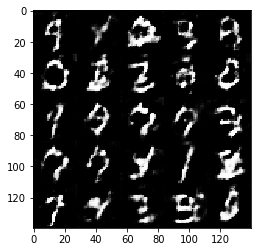

Epoch 2/2... Batch 110... Discriminator Loss: 0.7114... Generator Loss: 1.4398
Epoch 2/2... Batch 120... Discriminator Loss: 0.8174... Generator Loss: 1.1803
Epoch 2/2... Batch 130... Discriminator Loss: 1.2474... Generator Loss: 0.5582
Epoch 2/2... Batch 140... Discriminator Loss: 0.6419... Generator Loss: 1.1505
Epoch 2/2... Batch 150... Discriminator Loss: 0.6283... Generator Loss: 1.3679
Epoch 2/2... Batch 160... Discriminator Loss: 0.7475... Generator Loss: 1.3821
Epoch 2/2... Batch 170... Discriminator Loss: 0.6930... Generator Loss: 1.4683
Epoch 2/2... Batch 180... Discriminator Loss: 0.6542... Generator Loss: 2.1383
Epoch 2/2... Batch 190... Discriminator Loss: 0.8044... Generator Loss: 3.2470
Epoch 2/2... Batch 200... Discriminator Loss: 1.5821... Generator Loss: 0.4389


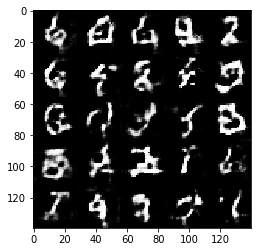

Epoch 2/2... Batch 210... Discriminator Loss: 0.9065... Generator Loss: 0.7690
Epoch 2/2... Batch 220... Discriminator Loss: 0.5627... Generator Loss: 1.6923
Epoch 2/2... Batch 230... Discriminator Loss: 0.7388... Generator Loss: 1.2972
Epoch 2/2... Batch 240... Discriminator Loss: 0.6765... Generator Loss: 1.2425
Epoch 2/2... Batch 250... Discriminator Loss: 0.5801... Generator Loss: 1.7372
Epoch 2/2... Batch 260... Discriminator Loss: 1.1221... Generator Loss: 3.3389
Epoch 2/2... Batch 270... Discriminator Loss: 0.8788... Generator Loss: 0.8858
Epoch 2/2... Batch 280... Discriminator Loss: 0.8146... Generator Loss: 2.3606
Epoch 2/2... Batch 290... Discriminator Loss: 0.8110... Generator Loss: 2.9835
Epoch 2/2... Batch 300... Discriminator Loss: 0.8992... Generator Loss: 1.6161


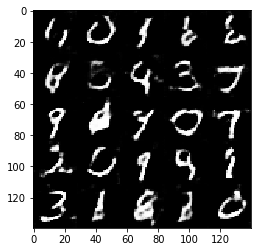

Epoch 2/2... Batch 310... Discriminator Loss: 0.6709... Generator Loss: 1.7128
Epoch 2/2... Batch 320... Discriminator Loss: 0.6613... Generator Loss: 1.6135
Epoch 2/2... Batch 330... Discriminator Loss: 1.0874... Generator Loss: 0.6281
Epoch 2/2... Batch 340... Discriminator Loss: 1.1782... Generator Loss: 0.5744
Epoch 2/2... Batch 350... Discriminator Loss: 0.8047... Generator Loss: 1.1188
Epoch 2/2... Batch 360... Discriminator Loss: 0.8091... Generator Loss: 2.1377
Epoch 2/2... Batch 370... Discriminator Loss: 0.6589... Generator Loss: 1.1246
Epoch 2/2... Batch 380... Discriminator Loss: 1.6001... Generator Loss: 0.3278
Epoch 2/2... Batch 390... Discriminator Loss: 1.2877... Generator Loss: 0.4729
Epoch 2/2... Batch 400... Discriminator Loss: 0.9445... Generator Loss: 0.7392


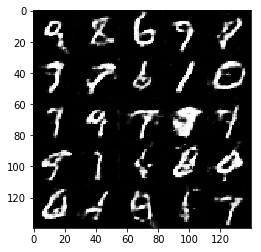

Epoch 2/2... Batch 410... Discriminator Loss: 0.9656... Generator Loss: 0.8461
Epoch 2/2... Batch 420... Discriminator Loss: 0.8541... Generator Loss: 1.0668
Epoch 2/2... Batch 430... Discriminator Loss: 0.6900... Generator Loss: 1.1271
Epoch 2/2... Batch 440... Discriminator Loss: 0.9364... Generator Loss: 2.8408
Epoch 2/2... Batch 450... Discriminator Loss: 0.9989... Generator Loss: 2.3079
Epoch 2/2... Batch 460... Discriminator Loss: 0.6228... Generator Loss: 1.3921


In [32]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.5926... Generator Loss: 0.5135
Epoch 1/1... Batch 20... Discriminator Loss: 0.6597... Generator Loss: 1.2723
Epoch 1/1... Batch 30... Discriminator Loss: 0.5502... Generator Loss: 1.4005
Epoch 1/1... Batch 40... Discriminator Loss: 0.3772... Generator Loss: 1.8397
Epoch 1/1... Batch 50... Discriminator Loss: 0.3351... Generator Loss: 1.9746
Epoch 1/1... Batch 60... Discriminator Loss: 0.3156... Generator Loss: 1.8610
Epoch 1/1... Batch 70... Discriminator Loss: 0.2618... Generator Loss: 2.4484
Epoch 1/1... Batch 80... Discriminator Loss: 0.1583... Generator Loss: 2.5185
Epoch 1/1... Batch 90... Discriminator Loss: 0.2538... Generator Loss: 2.1265
Epoch 1/1... Batch 100... Discriminator Loss: 0.1896... Generator Loss: 2.5594


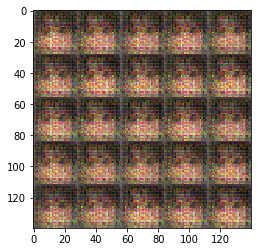

Epoch 1/1... Batch 110... Discriminator Loss: 0.2548... Generator Loss: 2.0318
Epoch 1/1... Batch 120... Discriminator Loss: 0.1937... Generator Loss: 2.8366
Epoch 1/1... Batch 130... Discriminator Loss: 0.0959... Generator Loss: 2.9896
Epoch 1/1... Batch 140... Discriminator Loss: 0.2652... Generator Loss: 2.1549
Epoch 1/1... Batch 150... Discriminator Loss: 0.1536... Generator Loss: 3.6092
Epoch 1/1... Batch 160... Discriminator Loss: 0.2866... Generator Loss: 2.0118
Epoch 1/1... Batch 170... Discriminator Loss: 0.1560... Generator Loss: 2.5869
Epoch 1/1... Batch 180... Discriminator Loss: 0.1187... Generator Loss: 2.9249
Epoch 1/1... Batch 190... Discriminator Loss: 0.1151... Generator Loss: 3.0884
Epoch 1/1... Batch 200... Discriminator Loss: 0.1135... Generator Loss: 2.9678


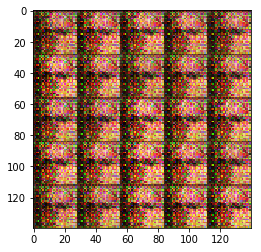

Epoch 1/1... Batch 210... Discriminator Loss: 0.1525... Generator Loss: 3.1766
Epoch 1/1... Batch 220... Discriminator Loss: 0.1235... Generator Loss: 3.2568
Epoch 1/1... Batch 230... Discriminator Loss: 0.2678... Generator Loss: 1.7926
Epoch 1/1... Batch 240... Discriminator Loss: 0.2372... Generator Loss: 4.2954
Epoch 1/1... Batch 250... Discriminator Loss: 0.1300... Generator Loss: 3.3116
Epoch 1/1... Batch 260... Discriminator Loss: 0.1118... Generator Loss: 3.7660
Epoch 1/1... Batch 270... Discriminator Loss: 0.1973... Generator Loss: 2.3974
Epoch 1/1... Batch 280... Discriminator Loss: 0.1444... Generator Loss: 3.0729
Epoch 1/1... Batch 290... Discriminator Loss: 0.0905... Generator Loss: 3.0990
Epoch 1/1... Batch 300... Discriminator Loss: 0.1025... Generator Loss: 3.1025


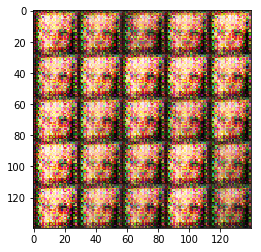

Epoch 1/1... Batch 310... Discriminator Loss: 0.1012... Generator Loss: 4.5749
Epoch 1/1... Batch 320... Discriminator Loss: 0.5905... Generator Loss: 1.0001
Epoch 1/1... Batch 330... Discriminator Loss: 0.1727... Generator Loss: 2.5050
Epoch 1/1... Batch 340... Discriminator Loss: 0.2832... Generator Loss: 1.9274
Epoch 1/1... Batch 350... Discriminator Loss: 0.3277... Generator Loss: 2.2064
Epoch 1/1... Batch 360... Discriminator Loss: 0.3539... Generator Loss: 3.9405
Epoch 1/1... Batch 370... Discriminator Loss: 0.4191... Generator Loss: 1.4428
Epoch 1/1... Batch 380... Discriminator Loss: 0.5508... Generator Loss: 1.0684
Epoch 1/1... Batch 390... Discriminator Loss: 0.4020... Generator Loss: 3.8521
Epoch 1/1... Batch 400... Discriminator Loss: 0.4142... Generator Loss: 1.5204


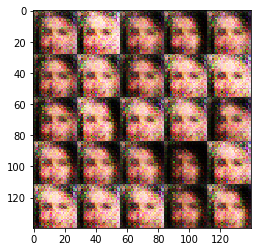

Epoch 1/1... Batch 410... Discriminator Loss: 0.2646... Generator Loss: 2.4543
Epoch 1/1... Batch 420... Discriminator Loss: 0.3297... Generator Loss: 1.8334
Epoch 1/1... Batch 430... Discriminator Loss: 0.2424... Generator Loss: 2.6189
Epoch 1/1... Batch 440... Discriminator Loss: 0.4643... Generator Loss: 1.5793
Epoch 1/1... Batch 450... Discriminator Loss: 0.2889... Generator Loss: 2.4476
Epoch 1/1... Batch 460... Discriminator Loss: 0.2893... Generator Loss: 1.8783
Epoch 1/1... Batch 470... Discriminator Loss: 0.3269... Generator Loss: 2.4328
Epoch 1/1... Batch 480... Discriminator Loss: 0.2650... Generator Loss: 3.1216
Epoch 1/1... Batch 490... Discriminator Loss: 0.3164... Generator Loss: 2.2979
Epoch 1/1... Batch 500... Discriminator Loss: 0.8886... Generator Loss: 4.6454


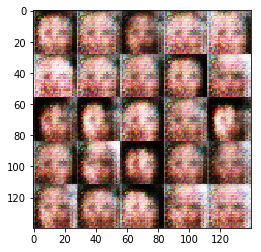

Epoch 1/1... Batch 510... Discriminator Loss: 0.4224... Generator Loss: 2.9442
Epoch 1/1... Batch 520... Discriminator Loss: 0.6414... Generator Loss: 2.7818
Epoch 1/1... Batch 530... Discriminator Loss: 0.4648... Generator Loss: 1.4652
Epoch 1/1... Batch 540... Discriminator Loss: 0.7073... Generator Loss: 1.1022
Epoch 1/1... Batch 550... Discriminator Loss: 0.5558... Generator Loss: 1.7323
Epoch 1/1... Batch 560... Discriminator Loss: 0.7091... Generator Loss: 3.0420
Epoch 1/1... Batch 570... Discriminator Loss: 0.6012... Generator Loss: 2.6456
Epoch 1/1... Batch 580... Discriminator Loss: 0.6752... Generator Loss: 1.3109
Epoch 1/1... Batch 590... Discriminator Loss: 0.5993... Generator Loss: 1.6881
Epoch 1/1... Batch 600... Discriminator Loss: 0.6406... Generator Loss: 2.1916


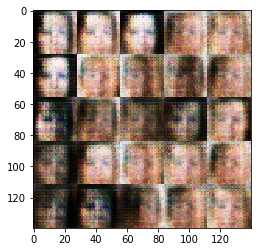

Epoch 1/1... Batch 610... Discriminator Loss: 0.8199... Generator Loss: 2.0761
Epoch 1/1... Batch 620... Discriminator Loss: 0.5796... Generator Loss: 1.6435
Epoch 1/1... Batch 630... Discriminator Loss: 0.8132... Generator Loss: 1.4033
Epoch 1/1... Batch 640... Discriminator Loss: 0.5382... Generator Loss: 1.6437
Epoch 1/1... Batch 650... Discriminator Loss: 0.8430... Generator Loss: 0.8492
Epoch 1/1... Batch 660... Discriminator Loss: 0.4072... Generator Loss: 2.3576
Epoch 1/1... Batch 670... Discriminator Loss: 0.4761... Generator Loss: 1.7827
Epoch 1/1... Batch 680... Discriminator Loss: 0.9856... Generator Loss: 1.0366
Epoch 1/1... Batch 690... Discriminator Loss: 0.4267... Generator Loss: 1.8492
Epoch 1/1... Batch 700... Discriminator Loss: 0.9255... Generator Loss: 1.1334


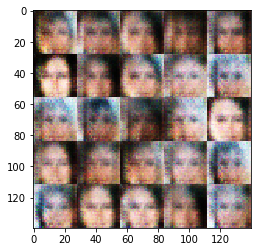

Epoch 1/1... Batch 710... Discriminator Loss: 0.5692... Generator Loss: 1.6346
Epoch 1/1... Batch 720... Discriminator Loss: 0.3950... Generator Loss: 2.5717
Epoch 1/1... Batch 730... Discriminator Loss: 1.0806... Generator Loss: 0.6849
Epoch 1/1... Batch 740... Discriminator Loss: 0.5618... Generator Loss: 1.2870
Epoch 1/1... Batch 750... Discriminator Loss: 0.8681... Generator Loss: 1.1035
Epoch 1/1... Batch 760... Discriminator Loss: 0.5514... Generator Loss: 1.5751
Epoch 1/1... Batch 770... Discriminator Loss: 0.5245... Generator Loss: 1.6984
Epoch 1/1... Batch 780... Discriminator Loss: 0.6985... Generator Loss: 2.0376
Epoch 1/1... Batch 790... Discriminator Loss: 0.9646... Generator Loss: 0.7918
Epoch 1/1... Batch 800... Discriminator Loss: 0.8526... Generator Loss: 0.7816


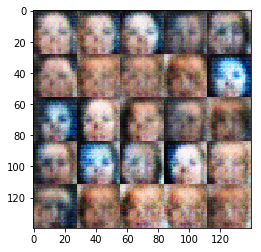

Epoch 1/1... Batch 810... Discriminator Loss: 0.6231... Generator Loss: 1.5865
Epoch 1/1... Batch 820... Discriminator Loss: 0.3987... Generator Loss: 2.5043
Epoch 1/1... Batch 830... Discriminator Loss: 0.7797... Generator Loss: 1.0744
Epoch 1/1... Batch 840... Discriminator Loss: 0.7950... Generator Loss: 1.5058
Epoch 1/1... Batch 850... Discriminator Loss: 0.7320... Generator Loss: 1.2053
Epoch 1/1... Batch 860... Discriminator Loss: 0.7950... Generator Loss: 1.4422
Epoch 1/1... Batch 870... Discriminator Loss: 0.8132... Generator Loss: 1.8933
Epoch 1/1... Batch 880... Discriminator Loss: 0.6157... Generator Loss: 1.3248
Epoch 1/1... Batch 890... Discriminator Loss: 0.6244... Generator Loss: 1.4437
Epoch 1/1... Batch 900... Discriminator Loss: 0.5738... Generator Loss: 1.5972


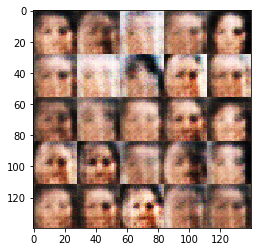

Epoch 1/1... Batch 910... Discriminator Loss: 0.5171... Generator Loss: 2.1076
Epoch 1/1... Batch 920... Discriminator Loss: 0.6707... Generator Loss: 1.8612
Epoch 1/1... Batch 930... Discriminator Loss: 0.6677... Generator Loss: 1.4066
Epoch 1/1... Batch 940... Discriminator Loss: 0.7330... Generator Loss: 1.1828
Epoch 1/1... Batch 950... Discriminator Loss: 0.5808... Generator Loss: 1.2900
Epoch 1/1... Batch 960... Discriminator Loss: 0.6533... Generator Loss: 1.7992
Epoch 1/1... Batch 970... Discriminator Loss: 0.6611... Generator Loss: 1.4190
Epoch 1/1... Batch 980... Discriminator Loss: 0.6705... Generator Loss: 1.5284
Epoch 1/1... Batch 990... Discriminator Loss: 0.7336... Generator Loss: 1.1482
Epoch 1/1... Batch 1000... Discriminator Loss: 0.7235... Generator Loss: 2.1767


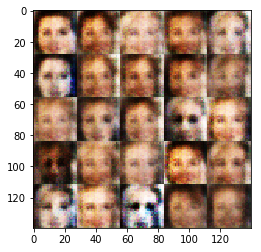

Epoch 1/1... Batch 1010... Discriminator Loss: 1.1808... Generator Loss: 0.7475
Epoch 1/1... Batch 1020... Discriminator Loss: 0.9051... Generator Loss: 1.7317
Epoch 1/1... Batch 1030... Discriminator Loss: 0.9634... Generator Loss: 0.8338
Epoch 1/1... Batch 1040... Discriminator Loss: 0.7053... Generator Loss: 1.2042
Epoch 1/1... Batch 1050... Discriminator Loss: 0.7116... Generator Loss: 1.2807
Epoch 1/1... Batch 1060... Discriminator Loss: 0.5731... Generator Loss: 1.8019
Epoch 1/1... Batch 1070... Discriminator Loss: 0.6575... Generator Loss: 1.7167
Epoch 1/1... Batch 1080... Discriminator Loss: 0.7294... Generator Loss: 1.0242
Epoch 1/1... Batch 1090... Discriminator Loss: 0.8460... Generator Loss: 1.1392
Epoch 1/1... Batch 1100... Discriminator Loss: 0.7385... Generator Loss: 1.8009


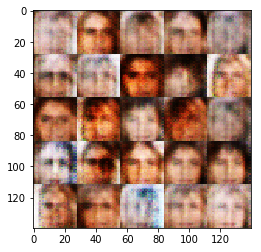

Epoch 1/1... Batch 1110... Discriminator Loss: 0.6955... Generator Loss: 2.1254
Epoch 1/1... Batch 1120... Discriminator Loss: 0.5167... Generator Loss: 1.6643
Epoch 1/1... Batch 1130... Discriminator Loss: 0.7503... Generator Loss: 1.3939
Epoch 1/1... Batch 1140... Discriminator Loss: 1.0616... Generator Loss: 0.6838
Epoch 1/1... Batch 1150... Discriminator Loss: 0.7189... Generator Loss: 1.5667
Epoch 1/1... Batch 1160... Discriminator Loss: 0.6543... Generator Loss: 1.5644
Epoch 1/1... Batch 1170... Discriminator Loss: 0.5352... Generator Loss: 1.8524
Epoch 1/1... Batch 1180... Discriminator Loss: 0.8188... Generator Loss: 1.3978
Epoch 1/1... Batch 1190... Discriminator Loss: 0.9704... Generator Loss: 1.0449
Epoch 1/1... Batch 1200... Discriminator Loss: 0.9978... Generator Loss: 2.2543


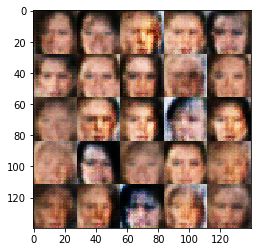

Epoch 1/1... Batch 1210... Discriminator Loss: 0.8033... Generator Loss: 0.8748
Epoch 1/1... Batch 1220... Discriminator Loss: 0.7079... Generator Loss: 1.7661
Epoch 1/1... Batch 1230... Discriminator Loss: 0.7745... Generator Loss: 1.4205
Epoch 1/1... Batch 1240... Discriminator Loss: 0.7770... Generator Loss: 1.0984
Epoch 1/1... Batch 1250... Discriminator Loss: 0.8092... Generator Loss: 1.1304
Epoch 1/1... Batch 1260... Discriminator Loss: 0.8733... Generator Loss: 0.9310
Epoch 1/1... Batch 1270... Discriminator Loss: 0.7910... Generator Loss: 1.6605
Epoch 1/1... Batch 1280... Discriminator Loss: 0.7723... Generator Loss: 1.2674
Epoch 1/1... Batch 1290... Discriminator Loss: 0.6955... Generator Loss: 1.2528
Epoch 1/1... Batch 1300... Discriminator Loss: 0.8439... Generator Loss: 1.0559


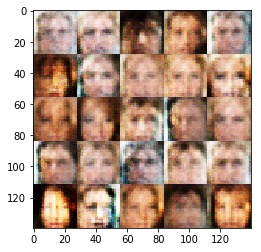

Epoch 1/1... Batch 1310... Discriminator Loss: 0.7492... Generator Loss: 1.2548
Epoch 1/1... Batch 1320... Discriminator Loss: 0.8099... Generator Loss: 1.6124
Epoch 1/1... Batch 1330... Discriminator Loss: 0.9347... Generator Loss: 1.3107
Epoch 1/1... Batch 1340... Discriminator Loss: 0.6724... Generator Loss: 1.2437
Epoch 1/1... Batch 1350... Discriminator Loss: 0.8566... Generator Loss: 1.0219
Epoch 1/1... Batch 1360... Discriminator Loss: 0.8938... Generator Loss: 1.3369
Epoch 1/1... Batch 1370... Discriminator Loss: 0.9017... Generator Loss: 0.8768
Epoch 1/1... Batch 1380... Discriminator Loss: 0.8848... Generator Loss: 1.3010
Epoch 1/1... Batch 1390... Discriminator Loss: 0.8638... Generator Loss: 1.9668
Epoch 1/1... Batch 1400... Discriminator Loss: 0.7380... Generator Loss: 1.0074


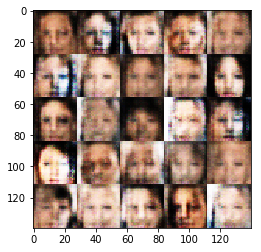

Epoch 1/1... Batch 1410... Discriminator Loss: 1.0574... Generator Loss: 1.7386
Epoch 1/1... Batch 1420... Discriminator Loss: 0.6781... Generator Loss: 1.6168
Epoch 1/1... Batch 1430... Discriminator Loss: 0.9177... Generator Loss: 0.8620
Epoch 1/1... Batch 1440... Discriminator Loss: 0.8127... Generator Loss: 1.5119
Epoch 1/1... Batch 1450... Discriminator Loss: 0.8219... Generator Loss: 1.0949
Epoch 1/1... Batch 1460... Discriminator Loss: 0.8209... Generator Loss: 1.5330
Epoch 1/1... Batch 1470... Discriminator Loss: 0.8152... Generator Loss: 1.0188
Epoch 1/1... Batch 1480... Discriminator Loss: 0.7758... Generator Loss: 1.4939
Epoch 1/1... Batch 1490... Discriminator Loss: 0.9674... Generator Loss: 1.7127
Epoch 1/1... Batch 1500... Discriminator Loss: 0.9267... Generator Loss: 0.8650


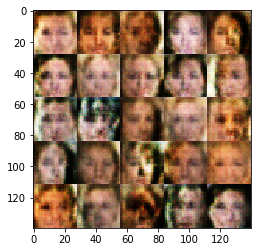

Epoch 1/1... Batch 1510... Discriminator Loss: 0.6739... Generator Loss: 1.4893
Epoch 1/1... Batch 1520... Discriminator Loss: 1.0218... Generator Loss: 0.7128
Epoch 1/1... Batch 1530... Discriminator Loss: 0.9644... Generator Loss: 0.9247
Epoch 1/1... Batch 1540... Discriminator Loss: 0.7912... Generator Loss: 1.3475
Epoch 1/1... Batch 1550... Discriminator Loss: 0.8602... Generator Loss: 1.0972
Epoch 1/1... Batch 1560... Discriminator Loss: 1.0121... Generator Loss: 1.5331
Epoch 1/1... Batch 1570... Discriminator Loss: 0.8943... Generator Loss: 1.6364
Epoch 1/1... Batch 1580... Discriminator Loss: 0.7653... Generator Loss: 1.6059
Epoch 1/1... Batch 1590... Discriminator Loss: 0.9142... Generator Loss: 0.9060
Epoch 1/1... Batch 1600... Discriminator Loss: 0.8725... Generator Loss: 1.0695


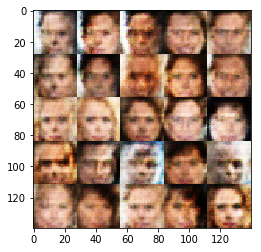

Epoch 1/1... Batch 1610... Discriminator Loss: 1.2587... Generator Loss: 0.6990
Epoch 1/1... Batch 1620... Discriminator Loss: 0.8344... Generator Loss: 1.1302
Epoch 1/1... Batch 1630... Discriminator Loss: 0.7666... Generator Loss: 1.6030
Epoch 1/1... Batch 1640... Discriminator Loss: 1.0372... Generator Loss: 1.8232
Epoch 1/1... Batch 1650... Discriminator Loss: 0.7131... Generator Loss: 1.7753
Epoch 1/1... Batch 1660... Discriminator Loss: 1.0289... Generator Loss: 0.7251
Epoch 1/1... Batch 1670... Discriminator Loss: 0.6886... Generator Loss: 1.4446
Epoch 1/1... Batch 1680... Discriminator Loss: 0.7114... Generator Loss: 1.3531
Epoch 1/1... Batch 1690... Discriminator Loss: 0.7683... Generator Loss: 1.2265
Epoch 1/1... Batch 1700... Discriminator Loss: 1.0469... Generator Loss: 1.0819


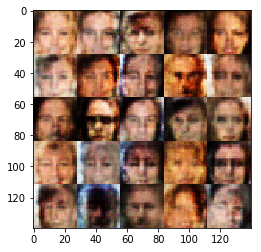

Epoch 1/1... Batch 1710... Discriminator Loss: 1.0218... Generator Loss: 0.7901
Epoch 1/1... Batch 1720... Discriminator Loss: 1.1221... Generator Loss: 0.7787
Epoch 1/1... Batch 1730... Discriminator Loss: 0.9310... Generator Loss: 2.1580
Epoch 1/1... Batch 1740... Discriminator Loss: 0.7701... Generator Loss: 1.6641
Epoch 1/1... Batch 1750... Discriminator Loss: 0.8677... Generator Loss: 1.0194
Epoch 1/1... Batch 1760... Discriminator Loss: 1.0198... Generator Loss: 1.2889
Epoch 1/1... Batch 1770... Discriminator Loss: 0.9635... Generator Loss: 0.9394
Epoch 1/1... Batch 1780... Discriminator Loss: 0.8737... Generator Loss: 1.1352
Epoch 1/1... Batch 1790... Discriminator Loss: 1.0633... Generator Loss: 0.7069
Epoch 1/1... Batch 1800... Discriminator Loss: 0.9021... Generator Loss: 1.3019


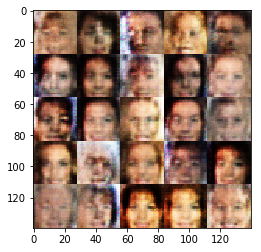

Epoch 1/1... Batch 1810... Discriminator Loss: 0.9033... Generator Loss: 1.3673
Epoch 1/1... Batch 1820... Discriminator Loss: 0.8123... Generator Loss: 1.3882
Epoch 1/1... Batch 1830... Discriminator Loss: 0.8033... Generator Loss: 1.1055
Epoch 1/1... Batch 1840... Discriminator Loss: 0.6437... Generator Loss: 1.6727
Epoch 1/1... Batch 1850... Discriminator Loss: 0.6645... Generator Loss: 1.2219
Epoch 1/1... Batch 1860... Discriminator Loss: 0.9726... Generator Loss: 2.3963
Epoch 1/1... Batch 1870... Discriminator Loss: 0.9432... Generator Loss: 1.5933
Epoch 1/1... Batch 1880... Discriminator Loss: 1.0707... Generator Loss: 0.7230
Epoch 1/1... Batch 1890... Discriminator Loss: 1.0166... Generator Loss: 1.4688
Epoch 1/1... Batch 1900... Discriminator Loss: 0.9371... Generator Loss: 1.0896


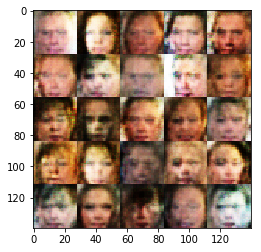

Epoch 1/1... Batch 1910... Discriminator Loss: 1.1516... Generator Loss: 0.6705
Epoch 1/1... Batch 1920... Discriminator Loss: 1.0306... Generator Loss: 1.1351
Epoch 1/1... Batch 1930... Discriminator Loss: 1.1446... Generator Loss: 0.7906
Epoch 1/1... Batch 1940... Discriminator Loss: 0.8218... Generator Loss: 1.3047
Epoch 1/1... Batch 1950... Discriminator Loss: 0.9504... Generator Loss: 1.2063
Epoch 1/1... Batch 1960... Discriminator Loss: 0.8546... Generator Loss: 1.3247
Epoch 1/1... Batch 1970... Discriminator Loss: 0.9057... Generator Loss: 1.4300
Epoch 1/1... Batch 1980... Discriminator Loss: 0.8283... Generator Loss: 1.0373
Epoch 1/1... Batch 1990... Discriminator Loss: 0.9311... Generator Loss: 0.9615
Epoch 1/1... Batch 2000... Discriminator Loss: 0.9387... Generator Loss: 1.0432


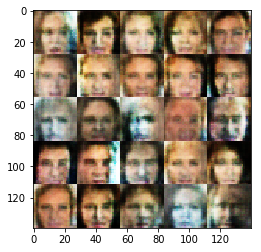

Epoch 1/1... Batch 2010... Discriminator Loss: 1.0365... Generator Loss: 0.9409
Epoch 1/1... Batch 2020... Discriminator Loss: 0.9283... Generator Loss: 1.0711
Epoch 1/1... Batch 2030... Discriminator Loss: 0.7014... Generator Loss: 1.3265
Epoch 1/1... Batch 2040... Discriminator Loss: 0.9398... Generator Loss: 1.3071
Epoch 1/1... Batch 2050... Discriminator Loss: 0.9218... Generator Loss: 1.5581
Epoch 1/1... Batch 2060... Discriminator Loss: 0.7336... Generator Loss: 1.6377
Epoch 1/1... Batch 2070... Discriminator Loss: 0.9045... Generator Loss: 0.8170
Epoch 1/1... Batch 2080... Discriminator Loss: 0.8944... Generator Loss: 1.2162
Epoch 1/1... Batch 2090... Discriminator Loss: 0.8237... Generator Loss: 1.0113
Epoch 1/1... Batch 2100... Discriminator Loss: 0.8889... Generator Loss: 0.8839


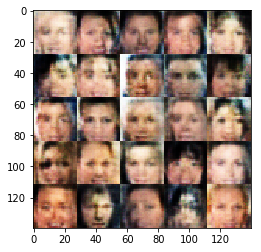

Epoch 1/1... Batch 2110... Discriminator Loss: 1.1615... Generator Loss: 0.5961
Epoch 1/1... Batch 2120... Discriminator Loss: 0.7535... Generator Loss: 1.6133
Epoch 1/1... Batch 2130... Discriminator Loss: 1.0072... Generator Loss: 1.3727
Epoch 1/1... Batch 2140... Discriminator Loss: 0.8667... Generator Loss: 1.1782
Epoch 1/1... Batch 2150... Discriminator Loss: 0.8069... Generator Loss: 1.3236
Epoch 1/1... Batch 2160... Discriminator Loss: 0.8803... Generator Loss: 0.9581
Epoch 1/1... Batch 2170... Discriminator Loss: 0.7634... Generator Loss: 1.1085
Epoch 1/1... Batch 2180... Discriminator Loss: 1.0916... Generator Loss: 0.8796
Epoch 1/1... Batch 2190... Discriminator Loss: 1.0577... Generator Loss: 0.8123
Epoch 1/1... Batch 2200... Discriminator Loss: 0.9578... Generator Loss: 0.8630


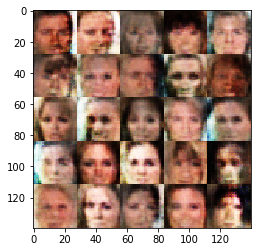

Epoch 1/1... Batch 2210... Discriminator Loss: 1.0332... Generator Loss: 1.3572
Epoch 1/1... Batch 2220... Discriminator Loss: 0.7606... Generator Loss: 1.3908
Epoch 1/1... Batch 2230... Discriminator Loss: 0.8960... Generator Loss: 0.8753
Epoch 1/1... Batch 2240... Discriminator Loss: 0.7331... Generator Loss: 1.2729
Epoch 1/1... Batch 2250... Discriminator Loss: 1.0362... Generator Loss: 0.7162
Epoch 1/1... Batch 2260... Discriminator Loss: 1.2068... Generator Loss: 0.9809
Epoch 1/1... Batch 2270... Discriminator Loss: 0.8896... Generator Loss: 0.8555
Epoch 1/1... Batch 2280... Discriminator Loss: 0.8283... Generator Loss: 1.0832
Epoch 1/1... Batch 2290... Discriminator Loss: 0.6619... Generator Loss: 1.5856
Epoch 1/1... Batch 2300... Discriminator Loss: 0.7795... Generator Loss: 1.1004


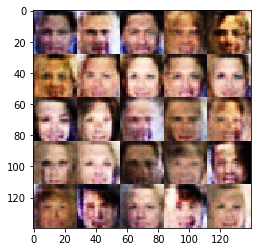

Epoch 1/1... Batch 2310... Discriminator Loss: 1.0237... Generator Loss: 0.8382
Epoch 1/1... Batch 2320... Discriminator Loss: 0.8540... Generator Loss: 1.1056
Epoch 1/1... Batch 2330... Discriminator Loss: 1.1315... Generator Loss: 1.5504
Epoch 1/1... Batch 2340... Discriminator Loss: 1.0219... Generator Loss: 0.8935
Epoch 1/1... Batch 2350... Discriminator Loss: 0.7242... Generator Loss: 1.5423
Epoch 1/1... Batch 2360... Discriminator Loss: 0.8470... Generator Loss: 1.0859
Epoch 1/1... Batch 2370... Discriminator Loss: 1.0055... Generator Loss: 0.9762
Epoch 1/1... Batch 2380... Discriminator Loss: 0.7928... Generator Loss: 1.3813
Epoch 1/1... Batch 2390... Discriminator Loss: 0.7838... Generator Loss: 1.0965
Epoch 1/1... Batch 2400... Discriminator Loss: 0.7991... Generator Loss: 1.3918


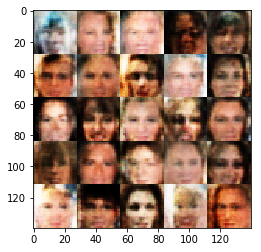

Epoch 1/1... Batch 2410... Discriminator Loss: 0.8408... Generator Loss: 1.2866
Epoch 1/1... Batch 2420... Discriminator Loss: 1.0758... Generator Loss: 0.8333
Epoch 1/1... Batch 2430... Discriminator Loss: 0.8886... Generator Loss: 0.8444
Epoch 1/1... Batch 2440... Discriminator Loss: 1.0970... Generator Loss: 1.0426
Epoch 1/1... Batch 2450... Discriminator Loss: 0.9684... Generator Loss: 1.0393
Epoch 1/1... Batch 2460... Discriminator Loss: 0.7772... Generator Loss: 1.1957
Epoch 1/1... Batch 2470... Discriminator Loss: 0.9927... Generator Loss: 1.0258
Epoch 1/1... Batch 2480... Discriminator Loss: 0.7335... Generator Loss: 1.3438
Epoch 1/1... Batch 2490... Discriminator Loss: 1.0896... Generator Loss: 0.9172
Epoch 1/1... Batch 2500... Discriminator Loss: 0.8197... Generator Loss: 1.1430


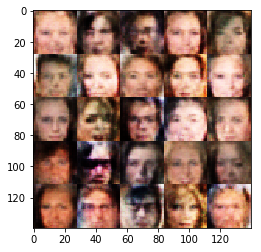

Epoch 1/1... Batch 2510... Discriminator Loss: 0.7944... Generator Loss: 1.2060
Epoch 1/1... Batch 2520... Discriminator Loss: 0.7235... Generator Loss: 1.3956
Epoch 1/1... Batch 2530... Discriminator Loss: 0.7279... Generator Loss: 1.2554
Epoch 1/1... Batch 2540... Discriminator Loss: 1.1153... Generator Loss: 0.8526
Epoch 1/1... Batch 2550... Discriminator Loss: 0.9154... Generator Loss: 1.3689
Epoch 1/1... Batch 2560... Discriminator Loss: 1.1500... Generator Loss: 0.9472
Epoch 1/1... Batch 2570... Discriminator Loss: 0.9434... Generator Loss: 0.7555
Epoch 1/1... Batch 2580... Discriminator Loss: 0.9744... Generator Loss: 0.8517
Epoch 1/1... Batch 2590... Discriminator Loss: 0.9182... Generator Loss: 1.4134
Epoch 1/1... Batch 2600... Discriminator Loss: 0.8818... Generator Loss: 1.0103


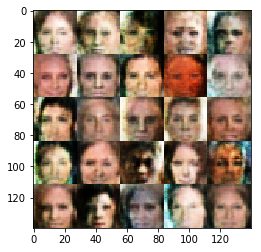

Epoch 1/1... Batch 2610... Discriminator Loss: 0.9273... Generator Loss: 1.2872
Epoch 1/1... Batch 2620... Discriminator Loss: 0.9698... Generator Loss: 1.1720
Epoch 1/1... Batch 2630... Discriminator Loss: 1.3828... Generator Loss: 0.6017
Epoch 1/1... Batch 2640... Discriminator Loss: 0.9266... Generator Loss: 1.2028
Epoch 1/1... Batch 2650... Discriminator Loss: 0.8858... Generator Loss: 1.3072
Epoch 1/1... Batch 2660... Discriminator Loss: 0.8275... Generator Loss: 1.2515
Epoch 1/1... Batch 2670... Discriminator Loss: 0.8986... Generator Loss: 1.2950
Epoch 1/1... Batch 2680... Discriminator Loss: 0.7821... Generator Loss: 1.0214
Epoch 1/1... Batch 2690... Discriminator Loss: 0.7668... Generator Loss: 1.3247
Epoch 1/1... Batch 2700... Discriminator Loss: 1.0725... Generator Loss: 1.3295


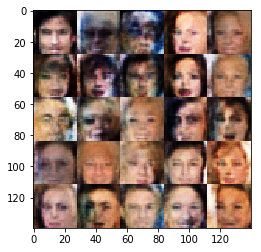

Epoch 1/1... Batch 2710... Discriminator Loss: 0.7706... Generator Loss: 1.5588
Epoch 1/1... Batch 2720... Discriminator Loss: 0.7537... Generator Loss: 1.0947
Epoch 1/1... Batch 2730... Discriminator Loss: 0.4324... Generator Loss: 1.9097
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2336... Generator Loss: 0.5859
Epoch 1/1... Batch 2750... Discriminator Loss: 0.8820... Generator Loss: 1.0602
Epoch 1/1... Batch 2760... Discriminator Loss: 0.8881... Generator Loss: 1.3242
Epoch 1/1... Batch 2770... Discriminator Loss: 1.2556... Generator Loss: 0.5422
Epoch 1/1... Batch 2780... Discriminator Loss: 0.8758... Generator Loss: 1.0078
Epoch 1/1... Batch 2790... Discriminator Loss: 1.3110... Generator Loss: 1.5542
Epoch 1/1... Batch 2800... Discriminator Loss: 1.0155... Generator Loss: 0.9851


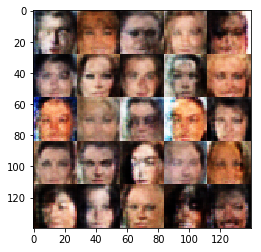

Epoch 1/1... Batch 2810... Discriminator Loss: 1.1201... Generator Loss: 0.6948
Epoch 1/1... Batch 2820... Discriminator Loss: 0.9094... Generator Loss: 1.0319
Epoch 1/1... Batch 2830... Discriminator Loss: 0.8108... Generator Loss: 1.7200
Epoch 1/1... Batch 2840... Discriminator Loss: 0.8539... Generator Loss: 1.3228
Epoch 1/1... Batch 2850... Discriminator Loss: 1.0677... Generator Loss: 0.7492
Epoch 1/1... Batch 2860... Discriminator Loss: 0.9211... Generator Loss: 1.2721
Epoch 1/1... Batch 2870... Discriminator Loss: 1.0281... Generator Loss: 0.8347
Epoch 1/1... Batch 2880... Discriminator Loss: 1.1150... Generator Loss: 0.9892
Epoch 1/1... Batch 2890... Discriminator Loss: 0.9284... Generator Loss: 1.2781
Epoch 1/1... Batch 2900... Discriminator Loss: 0.7947... Generator Loss: 1.1847


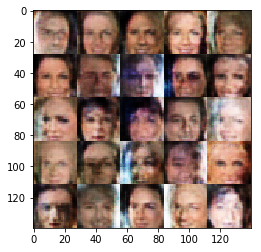

Epoch 1/1... Batch 2910... Discriminator Loss: 0.9020... Generator Loss: 1.1703
Epoch 1/1... Batch 2920... Discriminator Loss: 1.0138... Generator Loss: 0.8403
Epoch 1/1... Batch 2930... Discriminator Loss: 1.0107... Generator Loss: 0.8332
Epoch 1/1... Batch 2940... Discriminator Loss: 0.9877... Generator Loss: 0.7778
Epoch 1/1... Batch 2950... Discriminator Loss: 1.0992... Generator Loss: 1.1902
Epoch 1/1... Batch 2960... Discriminator Loss: 0.8647... Generator Loss: 0.8696
Epoch 1/1... Batch 2970... Discriminator Loss: 0.9466... Generator Loss: 1.4078
Epoch 1/1... Batch 2980... Discriminator Loss: 1.0327... Generator Loss: 0.8175
Epoch 1/1... Batch 2990... Discriminator Loss: 0.7280... Generator Loss: 1.2975
Epoch 1/1... Batch 3000... Discriminator Loss: 0.7767... Generator Loss: 1.1854


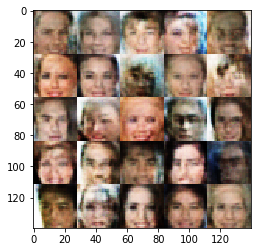

Epoch 1/1... Batch 3010... Discriminator Loss: 0.7973... Generator Loss: 1.3985
Epoch 1/1... Batch 3020... Discriminator Loss: 1.1751... Generator Loss: 0.7892
Epoch 1/1... Batch 3030... Discriminator Loss: 1.0484... Generator Loss: 1.0801
Epoch 1/1... Batch 3040... Discriminator Loss: 0.7864... Generator Loss: 1.3241
Epoch 1/1... Batch 3050... Discriminator Loss: 1.0081... Generator Loss: 1.2175
Epoch 1/1... Batch 3060... Discriminator Loss: 0.8922... Generator Loss: 1.3798
Epoch 1/1... Batch 3070... Discriminator Loss: 1.1004... Generator Loss: 0.8633
Epoch 1/1... Batch 3080... Discriminator Loss: 1.2008... Generator Loss: 0.4759
Epoch 1/1... Batch 3090... Discriminator Loss: 0.9590... Generator Loss: 1.2337
Epoch 1/1... Batch 3100... Discriminator Loss: 1.1004... Generator Loss: 0.8261


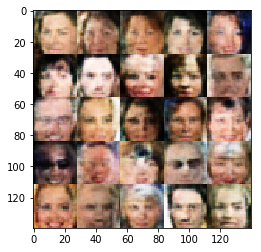

Epoch 1/1... Batch 3110... Discriminator Loss: 1.0297... Generator Loss: 0.7732
Epoch 1/1... Batch 3120... Discriminator Loss: 0.8331... Generator Loss: 1.3136
Epoch 1/1... Batch 3130... Discriminator Loss: 0.7834... Generator Loss: 1.0999
Epoch 1/1... Batch 3140... Discriminator Loss: 1.0742... Generator Loss: 0.9557
Epoch 1/1... Batch 3150... Discriminator Loss: 0.9031... Generator Loss: 1.0989
Epoch 1/1... Batch 3160... Discriminator Loss: 0.9192... Generator Loss: 1.1305


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.